# EMO1 - series areales
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 18-08-2023*<br>

**Introducción:**<br>

**Por hacer:**<br>
* [ ] Las series empiezan el 1 de enero de 1990 y terminan el 1 de enero del 2020. Deberían empezar el 1 de octubre de 2021 y terminar el 30 de septiembre de 2020.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm.notebook import tqdm
import xarray as xr
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cartopy.feature as cf
import yaml
from pathlib import Path

from funciones import polygon_statistics, read_static_map

## Configuración

In [2]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_efas = Path(cfg['rutas'].get('EFAS', '../data/EFASv5/'))
path_maps = path_efas / 'maps/'
# path_tables = path_efas / 'tables/'
path_meteo = path_efas / 'meteo/'

path_anuario = Path('../data/anuario_aforos/')

In [3]:
# inicio y fin del periodo de estudio
start = cfg['periodo'].get('inicio', None)
end = cfg['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

In [4]:
# # directorios con los datos de EFAS
# path_EFAS = 'C:/Users/jcr693/Documents/EFASv5/'
# path_maps = f'{path_EFAS}iberia/maps/'
# path_tables = f'{path_EFAS}iberia/tables/'
# path_meteo = f'{path_EFAS}iberia/meteo/'

# # directorio con las capas GIS
# path_GIS = '../data/anuario_aforos/GIS/'

# sistema de referencia de coordenadas de todos los datos
crs = 'epsg:4326'

# directorio donde guardar los resultados
path_out = '../data/EFASv5/atributos/'
if os.path.exists(path_out) is False:
    os.mkdir(path_out)

## Subcuencas

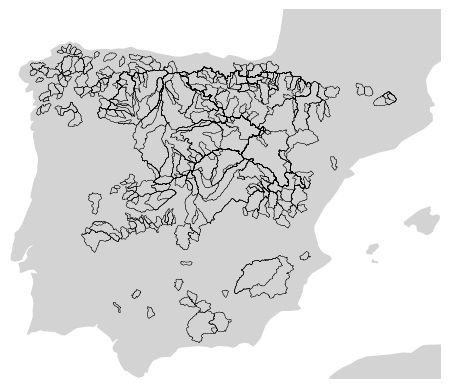

In [5]:
# cargar subcuencas
subcuencas = gpd.read_file(path_anuario / 'GIS/subcuencas_epsg4326.shp')
subcuencas.set_index('gauge_id', drop=False, inplace=True)

# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.3);
ax.axis('off');

## Mapas

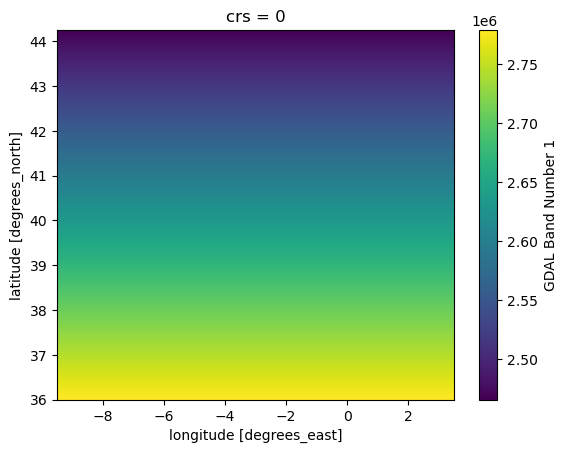

In [6]:
# cargar area de los pixels
pixarea = read_static_map(f'{path_maps}/pixarea*.nc', crs='epsg:4326')
pixarea.plot();

## Meteo

<font color='red'>Puesto que el LSTM calcula el caudal en mm/d, lo correcto sería que las series de precipitación y evapotranspiración fueran en mm. Sin embargo, como el área de las celdas no es idéntico, lo más correcto sería calcular la media areal como  una media ponderada por el área de cada celda.</font>

In [9]:
# cargar vagamente todos los datos meteorológicos
meteo = {var: xr.open_mfdataset(f'{path_meteo}/{var}/EMO*{var}*.nc', chunks='auto')[var] for var in ['pr', 'ta', 'e0']}
meteo = xr.Dataset(meteo)
# recortar al periodo de estudio
meteo = meteo.sel(time=slice(start, end))
# definir dimensiones con las coordenadas
meteo = meteo.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
# definir sistema de coordenadas
meteo = meteo.rio.write_crs('epsg:4326')

# convertir en volumen
# if var in ['pr', 'e0']:
#     da = da * area * 1e-3

# calcular medias areales
meteo_areal = polygon_statistics(meteo, subcuencas, func='mean', ponderacion=pixarea)
meteo_areal = meteo_areal.rename_vars({'pr_mean': 'pr_emo1', 'ta_mean': 'ta_emo1', 'e0_mean': 'e0_emo1'})
del meteo

# exportar series areales
for id in meteo_areal.id.data:
    meteo_areal.sel(id=id).to_netcdf(f'../data/EMO1/{id:04}.nc')

  0%|          | 0/287 [00:00<?, ?it/s]